# Grado en Robótica - Visión Artificial
## Práctica 4: Modelos de salencia espectrais e a súa avaliación
### Autor: Adrián Losada Álvarez

# Tarea 2: Saliencia dinámica

## Importamos las librerías necesarias

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import cv2
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import os
from IPython.display import Video

## **NOTA: Para la visualización de los resultados de los algoritmos no es necesario ejecutar ningún Kernel, en la parte inferior de cada implementación se encuentra un apartado "Resultado" con la grabación de los resultados respectivos de cada modelo.**

## Generalizamos el algoritmo de saliencia basado en la **fase global (PFT)** para vídeo incluyendo la información de color e invarianza a escala.

In [28]:
WIDTH = 64

# Función para cargar los frames de un video en una lista
def load_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_list = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_list.append(frame)
    cap.release()
    return frame_list

# Función para calcular el mapa de saliencia basado en el espectro de fase de la transformada de Fourier
def PFTVideo_Color_Multiescala(frame_list, num_scales=1, color_info=False):
    initial_rows, initial_cols = frame_list[0].shape[:2]

    # Crear la pirámide gaussiana
    pyramid = [frame_list]
    for _ in range(num_scales - 1):
        tmp = []
        for frame in pyramid[-1]:
            tmp.append(cv2.pyrDown(frame))
        pyramid.append(tmp)

    # Inicializar la lista donde se almacenarán los mapas de saliencia a distinta escala
    smSS = []

    for scaled_frame_list in pyramid:
        rows, cols = scaled_frame_list[0].shape[:2]

        # Agregar frames al principio y al final del video para evitar obtener información del futuro en el procesamiento
        black_frame = np.zeros((rows, cols, 3), dtype=np.uint8)
        num_frames = 30
        scaled_frame_list = [black_frame] * num_frames + scaled_frame_list

        # Redimensionamos todos los frames del video y pasamos a escala de grises si no se quiere utilizar información de color
        mod_scaled_frame_list = []

        if (color_info == False):
            for frame in scaled_frame_list:
                mod_scaled_frame_list.append(cv2.cvtColor(cv2.resize(frame, (WIDTH, int(WIDTH * frame.shape[0] / frame.shape[1]))), cv2.COLOR_BGR2GRAY))
        else:
            for frame in scaled_frame_list:
                mod_scaled_frame_list.append(cv2.resize(frame, (WIDTH, int(WIDTH * frame.shape[0] / frame.shape[1]))))

        # Si son frames en escala de grises, no podemos obtener información de los colores
        if (len(mod_scaled_frame_list[0].shape) == 2 or not color_info):
            # Transformada de Fourier
            fft = np.fft.fftn(np.array(mod_scaled_frame_list))

            # Espectro de la fase de la imagen
            phase_spectrum = np.angle(fft)

            # Suavizado y redimensionado del mapa de saliencia
            sm = cv2.GaussianBlur((np.abs(np.fft.ifftn(np.exp(1j * phase_spectrum))) ** 2),(15,15),5,5)

        # Si son imágenes a color
        else:
            # Obtener los canales B, G, R de cada frame
            B = [frame[:, :, 0] for frame in mod_scaled_frame_list]
            G = [frame[:, :, 1] for frame in mod_scaled_frame_list]
            R = [frame[:, :, 2] for frame in mod_scaled_frame_list]

            channels = [B, G, R]
            results = []

            # Para cada canal de diferencia
            for channel in channels:
                # Transformada de Fourier
                fft = np.fft.fftn(np.array(channel))

                # Espectro de la fase de la imagen
                phase_spectrum = np.angle(fft)

                # Suavizado y redimensionado del mapa de saliencia para el canal actual
                sm_channel = cv2.GaussianBlur((np.abs(np.fft.ifftn(np.exp(1j * phase_spectrum))) ** 2),(15,15),5,5)

                # Agregamos el mapa de saliencia del canal actual a la lista
                results.append(sm_channel)

            # Sumamos los mapas de saliencia de cada canal de color
            sm = np.sum(results, axis=0)

        # Eliminar los X frames agregados al principio y al final del video
        sm = sm[num_frames:]

        thisScale_sm = []
        for frame in sm:
            thisScale_sm.append(cv2.resize(frame, (cols, rows), cv2.INTER_LINEAR))

        # Agregar el mapa de saliencia de la escala actual a la lista
        smSS.append(thisScale_sm)

    # Juntar los mapas de saliencia a distintas escalas en uno único
    final_sm = []

    if (num_scales > 1):
        # Iterar sobre los frames
        for j in range(max(len(frames) for frames in smSS[1:])):  # Encontrar el número máximo de frames entre las escalas
            sum_frames = 0
            
            # Iterar sobre las escalas
            for frames in smSS:
                if j < len(frames):  # Asegurarse de que el frame existe en la escala actual
                    # Redimensionar el frame
                    scaled_frame = cv2.resize(frames[j], (initial_cols, initial_rows))
                    # Agregar el frame a la suma
                    sum_frames += scaled_frame
            
            # Agregar el sumatorio de escalas de frame actual al mapa final
            final_sm.append(cv2.normalize(sum_frames, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))

    else:
        for frame in smSS[0]:
            final_sm.append(cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8))

    return final_sm


# Directorio que contiene los videos
videos_dir = "./videos"
videos_list = os.listdir(videos_dir)
for video_name in videos_list:
    video_path = os.path.join(videos_dir, video_name)
    frame_list = load_video_frames(video_path)

    # Llamamos a la función para calcular el mapa de saliencia a multiescala con información de color e invariante a la escala
    sm_color = PFTVideo_Color_Multiescala(frame_list, num_scales=2, color_info=True)

    for frame in sm_color:
        # Visualización del mapa de saliencia
        cv2.imshow('Saliency map {}'.format(video_name), frame)

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    # Liberar recursos
    cv2.destroyAllWindows()

### Resultado

In [31]:
Video("./results/Dinamica/PFT_results.mp4")

### Análisis de los resultados
Observando los mapas de saliencia obtenidos se ha podido ver un efecto en el que los primeros frames presentaban información de los últimos debido a aplicar la transformada de Fourier a todos los frames del video en conjunto, para solucionar dicho problema se insertaron frames completamente en negro al principio de la lista de frames.

## Implementamos el algoritmo de **discrepancia en la fase (modelo Zhou et al)** incluyendo la información de color

In [29]:
def PD_Color(prev_frame, current_frame):
    # Si el video está en escala de grises
    if len(prev_frame.shape) == 2:
        # Calculamos la Transformada de Fourier 2D para cada fotograma
        FFT1 = np.fft.fft2(prev_frame)
        FFT2 = np.fft.fft2(current_frame)

        # Calculamos la magnitud y la fase de cada transformada de Fourier
        Amp1 = np.abs(FFT1)
        Amp2 = np.abs(FFT2)
        Phase1 = np.angle(FFT1)
        Phase2 = np.angle(FFT2)

        # Calculamos los mapas de magnitud
        mMap1 = np.abs(np.fft.ifft2((Amp2 - Amp1) * np.exp(1j * Phase1)))
        mMap2 = np.abs(np.fft.ifft2((Amp2 - Amp1) * np.exp(1j * Phase2)))

        # Calculamos el mapa combinado
        mMap = mMap1 * mMap2

        # Suavizado
        mMap = cv2.GaussianBlur(mMap,(85,85),20,20)

    # Si tiene canales de color
    else:
        # Obtenemos los canales de color
        prev_frame_channels = [prev_frame[:, :, 0], prev_frame[:, :, 1], prev_frame[:, :, 2]]
        current_frame_channels = [current_frame[:, :, 0], current_frame[:, :, 1], current_frame[:, :, 2]]
        results = []

        # Calculamos el mapa de saliencia para cada canal de color
        for i in range(len(prev_frame_channels)):
            # Calculamos la Transformada de Fourier 2D para cada fotograma
            FFT1 = np.fft.fft2(prev_frame_channels[i])
            FFT2 = np.fft.fft2(current_frame_channels[i])

            # Calculamos la magnitud y la fase de cada transformada de Fourier
            Amp1 = np.abs(FFT1)
            Amp2 = np.abs(FFT2)
            Phase1 = np.angle(FFT1)
            Phase2 = np.angle(FFT2)

            # Calculamos los mapas de magnitud
            mMap1 = np.abs(np.fft.ifft2((Amp2 - Amp1) * np.exp(1j * Phase1)))
            mMap2 = np.abs(np.fft.ifft2((Amp2 - Amp1) * np.exp(1j * Phase2)))

            # Calculamos el mapa combinado
            mMap_channel = mMap1 * mMap2

            # Suavizado
            mMap_channel = cv2.GaussianBlur(mMap_channel,(85,85),20,20)

            # Agregamos el mapa de saliencia del canal actual a la lista
            results.append(mMap_channel)

        # Sumamos los mapas de saliencia de cada canal de color
        mMap = np.sum(results, axis=0)

    # Normalización
    mMap_norm = cv2.normalize(mMap, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return mMap_norm


# Cargamos los videos
videos_list = os.listdir("./videos")
for i in range(len(videos_list)):
    video = cv2.VideoCapture("./videos/"+videos_list[i])

    # Leer el primer fotograma
    ret, prev_frame = video.read()

    # Iterar sobre los fotogramas del video
    while video.isOpened():
        ret, current_frame = video.read()
        if not ret:
            break

        # Llamamos a la función para calcular el mapa de saliencia a multiescala con información de color e invariante a la escala
        sm = PD_Color(prev_frame, current_frame)

        # Visualización
        cv2.imshow('Saliency map {}'.format(videos_list[i]), sm)

        # Actualizamos
        prev_frame = current_frame

        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

    # Liberar recursos
    video.release()
    cv2.destroyAllWindows()

### Resultado

In [32]:
Video("./results/Dinamica/PD_results.mp4")

## Analizamos los dos modelos implementados anteriormente
La estrategia para medir el rendimiento en video será la siguiente:
- Se analizará el rendimiento de todos los videos frame a frame para posteriormente calcular la media de los resultados de todos estos frames y así obtener un valor promedio.

### Definimos las funciones que calcularan las puntuaciones de cada mapa.

In [31]:
def normalize_map(s_map):
	# normalize the salience map
	norm_s_map = (s_map - np.min(s_map))/((np.max(s_map)-np.min(s_map))*1.0)
	return norm_s_map

def discretize_gt(gt):
	return gt/255

def AUC_judd(s_map,gt):
	# ground truth is discrete, s_map is continous and normalized
	gt = discretize_gt(gt)
	s_map = normalize_map(s_map)
	# thresholds are calculated from the salience map, only at places where fixations are present
	thresholds = []
	for i in range(0,gt.shape[0]):
		for k in range(0,gt.shape[1]):
			if gt[i][k]>0:
				thresholds.append(s_map[i][k])

	num_fixations = np.sum(gt)
	# num fixations is no. of salience map values at gt >0
	thresholds = sorted(set(thresholds))
	#fp_list = []
	#tp_list = []
	area = []
	area.append((0.0,0.0))
	for thresh in thresholds:
		# in the salience map, keep only those pixels with values above threshold
		temp = np.zeros(s_map.shape)
		temp[s_map>=thresh] = 1.0
		num_overlap = np.where(np.add(temp,gt)==2)[0].shape[0]
		tp = num_overlap/(num_fixations*1.0)
		
		# total number of pixels > threshold - number of pixels that overlap with gt / total number of non fixated pixels
		# this becomes nan when gt is full of fixations..this won't happen
		fp = (np.sum(temp) - num_overlap)/((np.shape(gt)[0] * np.shape(gt)[1]) - num_fixations)
		
		area.append((round(tp,4),round(fp,4)))
		#tp_list.append(tp)
		#fp_list.append(fp)

	#tp_list.reverse()
	#fp_list.reverse()
	area.append((1.0,1.0))
	#tp_list.append(1.0)
	#fp_list.append(1.0)
	#print tp_list
	area.sort(key = lambda x:x[0])
	tp_list =  [x[0] for x in area]
	fp_list =  [x[1] for x in area]
	return np.trapz(np.array(tp_list),np.array(fp_list))

def AUC_shuff(s_map,gt,other_map,splits=100,stepsize=0.1):
	gt = discretize_gt(gt)
	other_map = discretize_gt(other_map)
	s_map = normalize_map(s_map)

	num_fixations = np.sum(gt)
	
	x,y = np.where(other_map==1)
	other_map_fixs = []
	for j in zip(x,y):
		other_map_fixs.append(j[0]*other_map.shape[0] + j[1])
	ind = len(other_map_fixs)
	assert ind == len(other_map_fixs), 'something is wrong in auc shuffle'


	num_fixations_other = min(ind,num_fixations)

	num_pixels = s_map.shape[0]*s_map.shape[1]
	random_numbers = []
	for i in range(0,splits):
		temp_list = []
		t1 = np.random.permutation(ind)
		for k in t1:
			temp_list.append(other_map_fixs[k])
		random_numbers.append(temp_list)	

	aucs = []
	# for each split, calculate auc
	for i in random_numbers:
		r_sal_map = []
		for k in i:
			#print('{}  {}'.format(k%s_map.shape[0]-1, int(np.floor(k/s_map.shape[0]))))
			r_sal_map.append(s_map[k%s_map.shape[0]-1, int(np.floor(k/s_map.shape[0]))])
		# in these values, we need to find thresholds and calculate auc
		thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

		r_sal_map = np.array(r_sal_map)

		# once threshs are got
		thresholds = sorted(set(thresholds))
		area = []
		area.append((0.0,0.0))
		for thresh in thresholds:
			# in the salience map, keep only those pixels with values above threshold
			temp = np.zeros(s_map.shape)
			temp[s_map>=thresh] = 1.0
			num_overlap = np.where(np.add(temp,gt)==2)[0].shape[0]
			tp = num_overlap/(num_fixations*1.0)
			
			#fp = (np.sum(temp) - num_overlap)/((np.shape(gt)[0] * np.shape(gt)[1]) - num_fixations)
			# number of values in r_sal_map, above the threshold, divided by num of random locations = num of fixations
			fp = len(np.where(r_sal_map>thresh)[0])/(num_fixations*1.0)

			area.append((round(tp,4),round(fp,4)))
		
		area.append((1.0,1.0))
		area.sort(key = lambda x:x[0])
		tp_list =  [x[0] for x in area]
		fp_list =  [x[1] for x in area]

		aucs.append(np.trapz(np.array(tp_list),np.array(fp_list)))
	
	return np.mean(aucs)

def NSS(s_map,gt):
	gt = discretize_gt(gt)
	s_map_norm = (s_map - np.mean(s_map))/np.std(s_map)

	x,y = np.where(gt==1)
	temp = []
	for i in zip(x,y):
		temp.append(s_map_norm[i[0],i[1]])
	return np.mean(temp)


def CC(s_map,gt):
	s_map_norm = (s_map - np.mean(s_map))/np.std(s_map)
	gt_norm = (gt - np.mean(gt))/np.std(gt)
	a = s_map_norm
	b= gt_norm
	r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum())
	return r

### Definimos el directorio de la base de datos, las fijaciones y el número de videos a procesar.

In [32]:
# Definimos el path a los videos
videos_path = './videos/'

# Cargamos los mapas de fijación
fixation_maps =  sio.loadmat('./FixVideoData.mat')

# Definimos el número de videos a procesar
nvideos = 6

### Calculamos los resultados para el modelo de la **fase global (PFT)** y de la **discrepancia de fase (PD)** **SIN** información de color

In [33]:
# Definimos las listas donde guardaremos los distintos valores de las métricas para finalmente calcular la media
# Fase global:
PFT_AUCjudd_scores = []
PFT_AUCshuff_scores = []
PFT_NSS_scores = []
PFT_CC_scores = []

# Discrepancia de la fase:
PD_AUCjudd_scores = []
PD_AUCshuff_scores = []
PD_NSS_scores = []
PD_CC_scores = []


# Recorremos la base de datos con los videos iniciales
for ivideo in range(fixation_maps['EyeTrackVDB'].shape[0]):
    # Leemos el video y el mapa de fijación correspondiente
    name_video = fixation_maps['EyeTrackVDB'][ivideo]['Name'][0][0]
    video = cv2.VideoCapture(videos_path + name_video)

    if (video.isOpened() == False):
        print("Error en la apertura del fichero {}".format(videos_path + name_video))

    # Recuperamos as propieades do video.
    frame_w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Obtenemos el video del mapa de saliencia de la fase global
    PFT_sm_video = PFTVideo_Color_Multiescala(load_video_frames(videos_path + name_video), num_scales=1, color_info=False)

    frame_count = 0
    ret, prev_frame = video.read()
    while(True):
        ret, current_frame = video.read()
        if(not ret):
            break

        # Leemos las fijaciones correspondientes al frame actual y a otro frame aleatorio
        fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,frame_count][:,0:2]
        random_frame = np.random.randint(len(fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0]))
        random_fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,random_frame][:,0:2]

        # Construimos los mapas de fijaciones del frame actual y del aleatorio
        # Frame actual:
        ground_truth = np.zeros((frame_h,frame_w))
        for ifix in range(fix.shape[0]):
            # Puede haber fijaciones fuera de los margenes de la imagen
            if(int(fix[ifix][0]) < frame_h and int(fix[ifix][1]) < frame_w):
                ground_truth[int(fix[ifix][1]), int(fix[ifix][0])] = 255
        # Convolucionamos con una gaussiana las fijaciones para obtener el mapa de densidad de fijaciones
        density_map = (np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(ground_truth),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX))).astype(np.uint8)

        # Frame aleatorio:
        random_ground_truth = np.zeros((frame_h,frame_w))
        for ifix in range(random_fix.shape[0]):
            # Puede haber fijaciones fuera de los margenes de la imagen
            if(int(random_fix[ifix][0]) < frame_h and int(random_fix[ifix][1]) < frame_w):
                random_ground_truth[int(random_fix[ifix][1]), int(random_fix[ifix][0])] = 255

        # Pasamos los frames a escala de grises para no utilizar la información de color
        if len(prev_frame.shape) != 2:
            prev_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        if len(current_frame.shape) != 2:
            current_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

        # Obtenemos el mapa de saliencia para los frames
        PFT_sm_frame = PFT_sm_video[frame_count]  # Fase global
        PD_sm = PD_Color(prev_frame, current_frame)  # Discrepancia de la fase

        # Calculamos las diferentes métricas para cada frame
        # Fase global:
        PFT_AUCjudd_scores.append(AUC_judd(PFT_sm_frame, ground_truth))
        PFT_AUCshuff_scores.append(AUC_shuff(PFT_sm_frame, ground_truth, random_ground_truth))
        PFT_NSS_scores.append(NSS(PFT_sm_frame, ground_truth))
        PFT_CC_scores.append(CC(PFT_sm_frame, density_map))

        # Discrepancia de la fase:
        PD_AUCjudd_scores.append(AUC_judd(PD_sm, ground_truth))
        PD_AUCshuff_scores.append(AUC_shuff(PD_sm, ground_truth, random_ground_truth))
        PD_NSS_scores.append(NSS(PD_sm, ground_truth))
        PD_CC_scores.append(CC(PD_sm, density_map))

        # Actualizamos los frames
        frame_count += 1
        prev_frame = current_frame

# Calculamos la media de la métricas
# Fase global:
PFT_AUCjudd_mean = np.mean(np.nan_to_num(PFT_AUCjudd_scores))
PFT_AUCshuff_mean = np.mean(np.nan_to_num(PFT_AUCshuff_scores))
PFT_NSS_mean = np.mean(np.nan_to_num(PFT_NSS_scores))
PFT_CC_mean = np.mean(np.nan_to_num(PFT_CC_scores))

# Discrepancia de la fase:
PD_AUCjudd_mean = np.mean(np.nan_to_num(PD_AUCjudd_scores))
PD_AUCshuff_mean = np.mean(np.nan_to_num(PD_AUCshuff_scores))
PD_NSS_mean = np.mean(np.nan_to_num(PD_NSS_scores))
PD_CC_mean = np.mean(np.nan_to_num(PD_CC_scores))

/tmp/ipykernel_13103/1916560951.py:3: RuntimeWarning: invalid value encountered in divide
  norm_s_map = (s_map - np.min(s_map))/((np.max(s_map)-np.min(s_map))*1.0)
/tmp/ipykernel_13103/1916560951.py:119: RuntimeWarning: invalid value encountered in divide
  s_map_norm = (s_map - np.mean(s_map))/np.std(s_map)
/tmp/ipykernel_13103/1916560951.py:129: RuntimeWarning: invalid value encountered in divide
  s_map_norm = (s_map - np.mean(s_map))/np.std(s_map)
/tmp/ipykernel_13103/1916560951.py:100: RuntimeWarning: invalid value encountered in scalar divide
  tp = num_overlap/(num_fixations*1.0)
/tmp/ipykernel_13103/1916560951.py:104: RuntimeWarning: invalid value encountered in scalar divide
  fp = len(np.where(r_sal_map>thresh)[0])/(num_fixations*1.0)
/home/adrian/.virtualenvs/VAA/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/adrian/.virtualenvs/VAA/lib/python3.8/site-packages/numpy/co

### Calculamos los resultados para el modelo de la **fase global (PFT)** y de la **discrepancia de fase (PD)** **CON** información de color

In [34]:
# Definimos las listas donde guardaremos los distintos valores de las métricas para finalmente calcular la media
# Fase global:
PFTColor_AUCjudd_scores = []
PFTColor_AUCshuff_scores = []
PFTColor_NSS_scores = []
PFTColor_CC_scores = []

# Discrepancia de la fase:
PDColor_AUCjudd_scores = []
PDColor_AUCshuff_scores = []
PDColor_NSS_scores = []
PDColor_CC_scores = []


# Recorremos la base de datos con los videos iniciales
for ivideo in range(fixation_maps['EyeTrackVDB'].shape[0]):
    # Leemos el video y el mapa de fijación correspondiente
    name_video = fixation_maps['EyeTrackVDB'][ivideo]['Name'][0][0]
    video = cv2.VideoCapture(videos_path + name_video)

    if (video.isOpened() == False):
        print("Error en la apertura del fichero {}".format(videos_path + name_video))

    # Recuperamos as propieades do video.
    frame_w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Obtenemos el video del mapa de saliencia de la fase global
    PFT_sm_video = PFTVideo_Color_Multiescala(load_video_frames(videos_path + name_video), num_scales=1, color_info=True)

    frame_count = 0
    ret, prev_frame = video.read()
    while(True):
        ret, current_frame = video.read()
        if(not ret):
            break

        # Leemos las fijaciones correspondientes al frame actual y a otro frame aleatorio
        fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,frame_count][:,0:2]
        random_frame = np.random.randint(len(fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0]))
        random_fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,random_frame][:,0:2]

        # Construimos los mapas de fijaciones del frame actual y del aleatorio
        # Frame actual:
        ground_truth = np.zeros((frame_h,frame_w))
        for ifix in range(fix.shape[0]):
            # Puede haber fijaciones fuera de los margenes de la imagen
            if(int(fix[ifix][0]) < frame_h and int(fix[ifix][1]) < frame_w):
                ground_truth[int(fix[ifix][1]), int(fix[ifix][0])] = 255   # Mapa de fijaciones
        # Convolucionamos con una gaussiana las fijaciones para obtener el mapa de densidad de fijaciones (necesario para la métrica CC)
        density_map = (np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(ground_truth),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX))).astype(np.uint8)

        # Frame aleatorio:
        random_ground_truth = np.zeros((frame_h,frame_w))
        for ifix in range(random_fix.shape[0]):
            # Puede haber fijaciones fuera de los margenes de la imagen
            if(int(random_fix[ifix][0]) < frame_h and int(random_fix[ifix][1]) < frame_w):
                random_ground_truth[int(random_fix[ifix][1]), int(random_fix[ifix][0])] = 255 # Mapa de fijaciones

        # Obtenemos el mapa de saliencia para el frame
        PFTColor_sm_frame = PFT_sm_video[frame_count]  # Fase global
        PDColor_sm = PD_Color(prev_frame, current_frame)  # Discrepancia de la fase

        # Calculamos las diferentes métricas para cada frame
        # Fase global:
        PFTColor_AUCjudd_scores.append(AUC_judd(PFTColor_sm_frame, ground_truth))
        PFTColor_AUCshuff_scores.append(AUC_shuff(PFTColor_sm_frame, ground_truth, random_ground_truth))
        PFTColor_NSS_scores.append(NSS(PFTColor_sm_frame, ground_truth))
        PFTColor_CC_scores.append(CC(PFTColor_sm_frame, density_map))

        # Discrepancia de la fase:
        PDColor_AUCjudd_scores.append(AUC_judd(PDColor_sm, ground_truth))
        PDColor_AUCshuff_scores.append(AUC_shuff(PDColor_sm, ground_truth, random_ground_truth))
        PDColor_NSS_scores.append(NSS(PDColor_sm, ground_truth))
        PDColor_CC_scores.append(CC(PDColor_sm, density_map))

        # Actualizamos los frames
        frame_count += 1
        prev_frame = current_frame

# Calculamos la media de la métricas
# Fase global:
PFTColor_AUCjudd_mean = np.mean(np.nan_to_num(PFTColor_AUCjudd_scores))
PFTColor_AUCshuff_mean = np.mean(np.nan_to_num(PFTColor_AUCshuff_scores))
PFTColor_NSS_mean = np.mean(np.nan_to_num(PFTColor_NSS_scores))
PFTColor_CC_mean = np.mean(np.nan_to_num(PFTColor_CC_scores))

# Discrepancia de la fase:
PDColor_AUCjudd_mean = np.mean(np.nan_to_num(PDColor_AUCjudd_scores))
PDColor_AUCshuff_mean = np.mean(np.nan_to_num(PDColor_AUCshuff_scores))
PDColor_NSS_mean = np.mean(np.nan_to_num(PDColor_NSS_scores))
PDColor_CC_mean = np.mean(np.nan_to_num(PDColor_CC_scores))

/tmp/ipykernel_13103/1916560951.py:3: RuntimeWarning: invalid value encountered in divide
  norm_s_map = (s_map - np.min(s_map))/((np.max(s_map)-np.min(s_map))*1.0)
/tmp/ipykernel_13103/1916560951.py:119: RuntimeWarning: invalid value encountered in divide
  s_map_norm = (s_map - np.mean(s_map))/np.std(s_map)
/tmp/ipykernel_13103/1916560951.py:129: RuntimeWarning: invalid value encountered in divide
  s_map_norm = (s_map - np.mean(s_map))/np.std(s_map)
/tmp/ipykernel_13103/1916560951.py:100: RuntimeWarning: invalid value encountered in scalar divide
  tp = num_overlap/(num_fixations*1.0)
/tmp/ipykernel_13103/1916560951.py:104: RuntimeWarning: invalid value encountered in scalar divide
  fp = len(np.where(r_sal_map>thresh)[0])/(num_fixations*1.0)
/tmp/ipykernel_13103/1916560951.py:130: RuntimeWarning: invalid value encountered in divide
  gt_norm = (gt - np.mean(gt))/np.std(gt)


### Modelo de la **gaussiana centrada** en la imagen

#### Definimos la función que creará la gaussiana centrada en la imagen

In [35]:
# Función que crea la gaussiana
def CreateGaussian(shape, sigma):
    # Cuadrícula con las dimensiones dadas
    x, y = np.meshgrid(np.arange(0, shape[1]), np.arange(0, shape[0]))

    # Centro de la imagen
    center_x, center_y = shape[1] // 2, shape[0] // 2

    # Crear la gaussiana en el centro de la imagen
    gaussian = np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * sigma**2))

    # Normalizar
    gaussian = cv2.normalize(gaussian, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return gaussian

#### Obtenemos los valores de las métricas

In [36]:
# Definimos las listas donde guardaremos los distintos valores de las métricas para finalmente calcular la media
gaussian_AUCjudd_scores = []
gaussian_AUCshuff_scores = []
gaussian_NSS_scores = []
gaussian_CC_scores = []


# Recorremos la base de datos con los videos iniciales
for ivideo in range(fixation_maps['EyeTrackVDB'].shape[0]):
    # Leemos el video y el mapa de fijación correspondiente
    name_video = fixation_maps['EyeTrackVDB'][ivideo]['Name'][0][0]
    video = cv2.VideoCapture(videos_path + name_video)

    if (video.isOpened() == False):
        print("Error en la apertura del fichero {}".format(videos_path + name_video))

    # Recuperamos as propieades do video.
    frame_w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Definimos parámetros y creamos la gaussiana
    shape = (frame_h, frame_w)
    sigma = 75
    gaussian_sm = CreateGaussian(shape, sigma)

    frame_count = 0
    ret, prev_frame = video.read()
    while(True):
        ret, current_frame = video.read()
        if(not ret):
            break

        # Leemos las fijaciones correspondientes al frame actual y a otro frame aleatorio
        fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,frame_count][:,0:2]
        random_frame = np.random.randint(len(fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0]))
        random_fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,random_frame][:,0:2]

        # Construimos los mapas de fijaciones del frame actual y del aleatorio
        # Frame actual:
        ground_truth = np.zeros((frame_h,frame_w))
        for ifix in range(fix.shape[0]):
            # Puede haber fijaciones fuera de los margenes de la imagen
            if(int(fix[ifix][0]) < frame_h and int(fix[ifix][1]) < frame_w):
                ground_truth[int(fix[ifix][1]), int(fix[ifix][0])] = 255
        # Convolucionamos con una gaussiana las fijaciones para obtener el mapa de densidad de fijaciones
        density_map = (np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(ground_truth),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX))).astype(np.uint8)

        # Frame aleatorio:
        random_ground_truth = np.zeros((frame_h,frame_w))
        for ifix in range(random_fix.shape[0]):
            # Puede haber fijaciones fuera de los margenes de la imagen
            if(int(random_fix[ifix][0]) < frame_h and int(random_fix[ifix][1]) < frame_w):
                random_ground_truth[int(random_fix[ifix][1]), int(random_fix[ifix][0])] = 255

        # Calculamos las diferentes métricas para cada frame
        gaussian_AUCjudd_scores.append(AUC_judd(gaussian_sm, ground_truth))
        gaussian_AUCshuff_scores.append(AUC_shuff(gaussian_sm, ground_truth, random_ground_truth))
        gaussian_NSS_scores.append(NSS(gaussian_sm, ground_truth))
        gaussian_CC_scores.append(CC(gaussian_sm, density_map))

        # Actualizamos los frames
        frame_count += 1
        prev_frame = current_frame

# Calculamos la media de la métricas
gaussian_AUCjudd_mean = np.mean(np.nan_to_num(gaussian_AUCjudd_scores))
gaussian_AUCshuff_mean = np.mean(np.nan_to_num(gaussian_AUCshuff_scores))
gaussian_NSS_mean = np.mean(np.nan_to_num(gaussian_NSS_scores))
gaussian_CC_mean = np.mean(np.nan_to_num(gaussian_CC_scores))

/tmp/ipykernel_13103/1916560951.py:100: RuntimeWarning: invalid value encountered in scalar divide
  tp = num_overlap/(num_fixations*1.0)
/tmp/ipykernel_13103/1916560951.py:104: RuntimeWarning: divide by zero encountered in scalar divide
  fp = len(np.where(r_sal_map>thresh)[0])/(num_fixations*1.0)
/home/adrian/.virtualenvs/VAA/lib/python3.8/site-packages/numpy/lib/function_base.py:1448: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/tmp/ipykernel_13103/1916560951.py:130: RuntimeWarning: invalid value encountered in divide
  gt_norm = (gt - np.mean(gt))/np.std(gt)


### Modelo del **superhumano**

##### En primer lugar, construimos la gaussiana que simulará el campo de visión del superhumano

In [37]:
def build_superhumanFOV(d=0.75, pulgadas_diagonal=21):  # Datos proporcionados
    d = d    # Distancia del sujeto a la pantalla (en metros)
    pulgadas_diagonal = pulgadas_diagonal  # Tamaño diagonal de la pantalla en pulgadas
    metros_diagonal = pulgadas_diagonal * 0.0254    # Convertir pulgadas a metros

    # Calcular el ángulo visual en radianes
    theta = 2 * np.arctan(metros_diagonal/(2*d))

    # Convertir radianes a grados
    sigma = np.degrees(theta)

    # Creamos la matriz 2D de la gaussiana
    size = int(2*np.ceil(3*sigma)+1)
    x = np.linspace(-(size//2), size//2, size)
    y = np.linspace(-(size//2), size//2, size)
    X, Y = np.meshgrid(x, y)
    gaussian = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    gaussian /= np.sum(gaussian)

    return gaussian

#### **Modelo 1**: utilizando como mapa de saliencia únicamente el mapa de fijaciones actual.

##### Obtenemos el mapa de fijaciones actual y lo convolucionamos con la gaussiana para crear el mapa de saliencia del superhumano

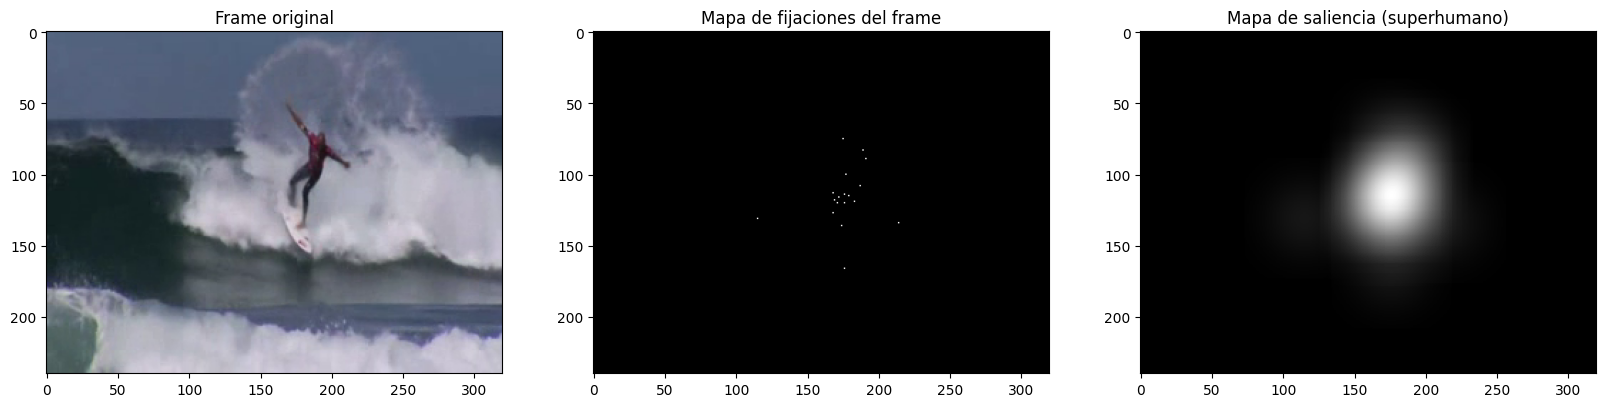

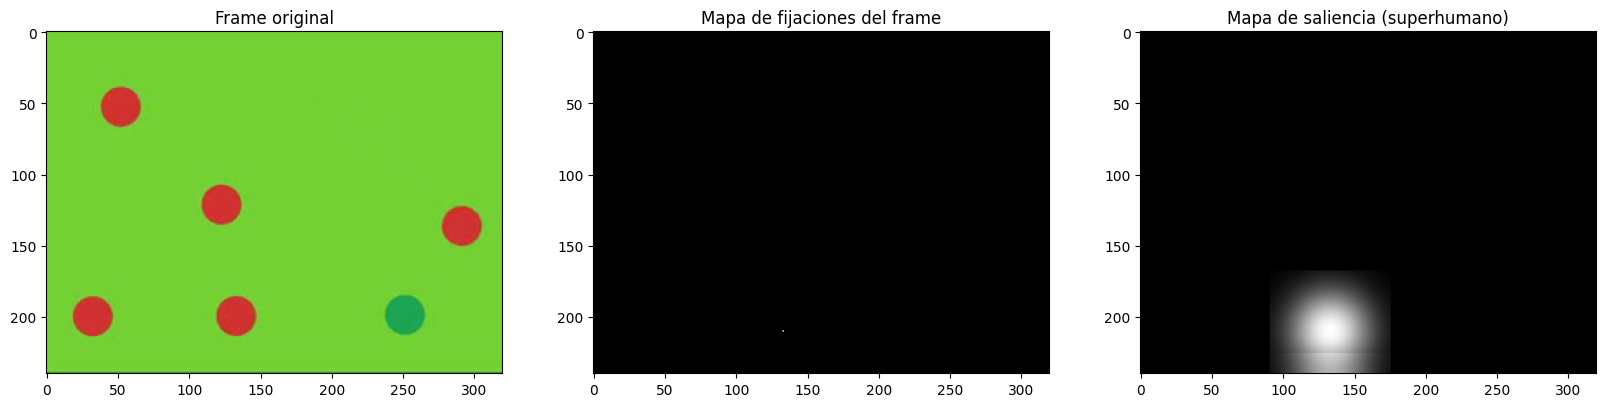

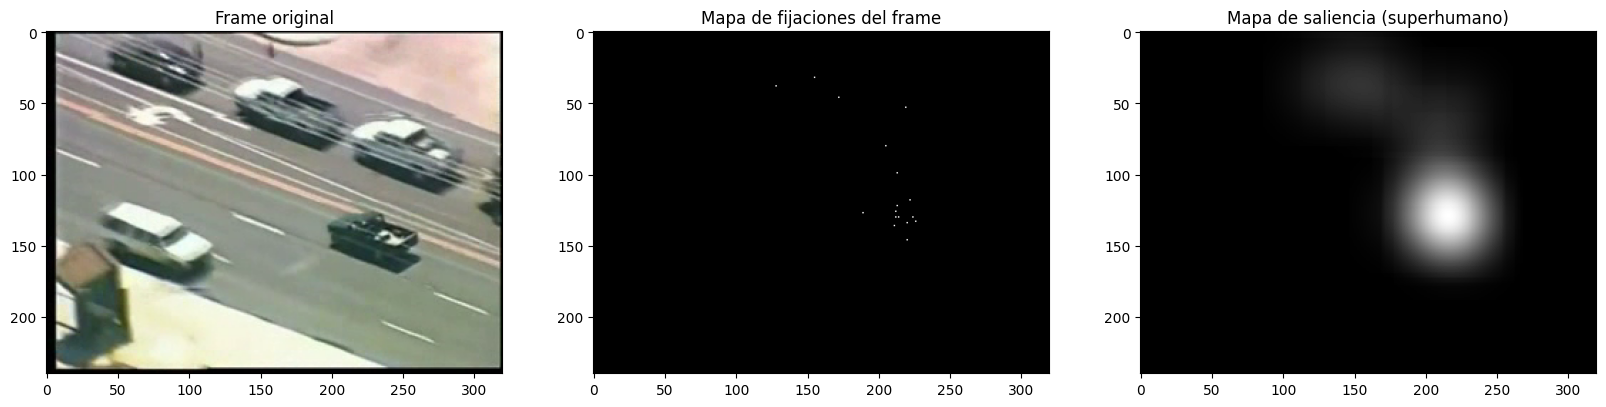

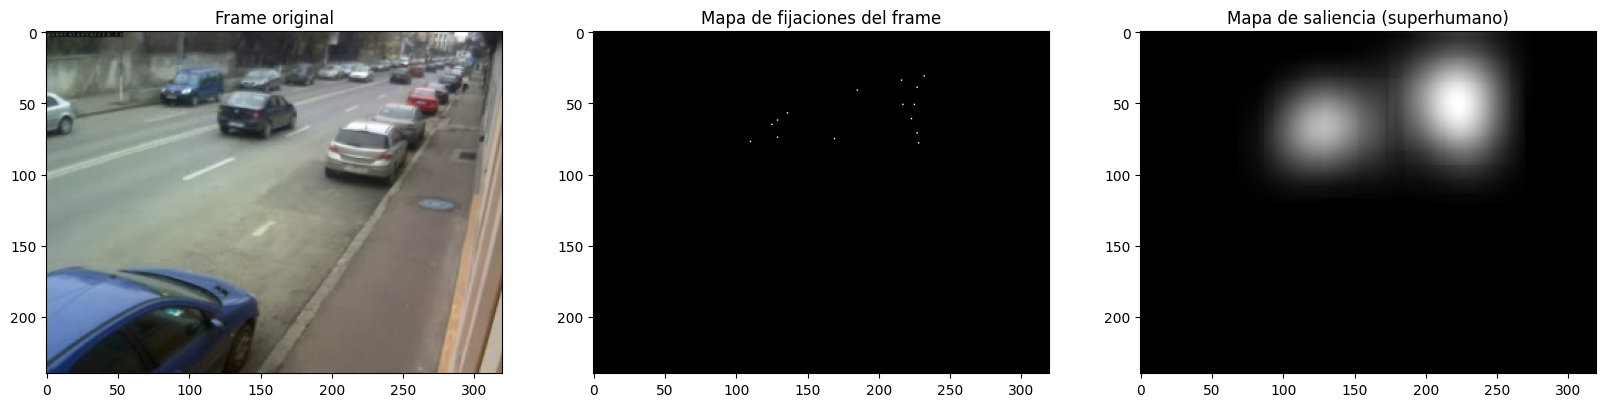

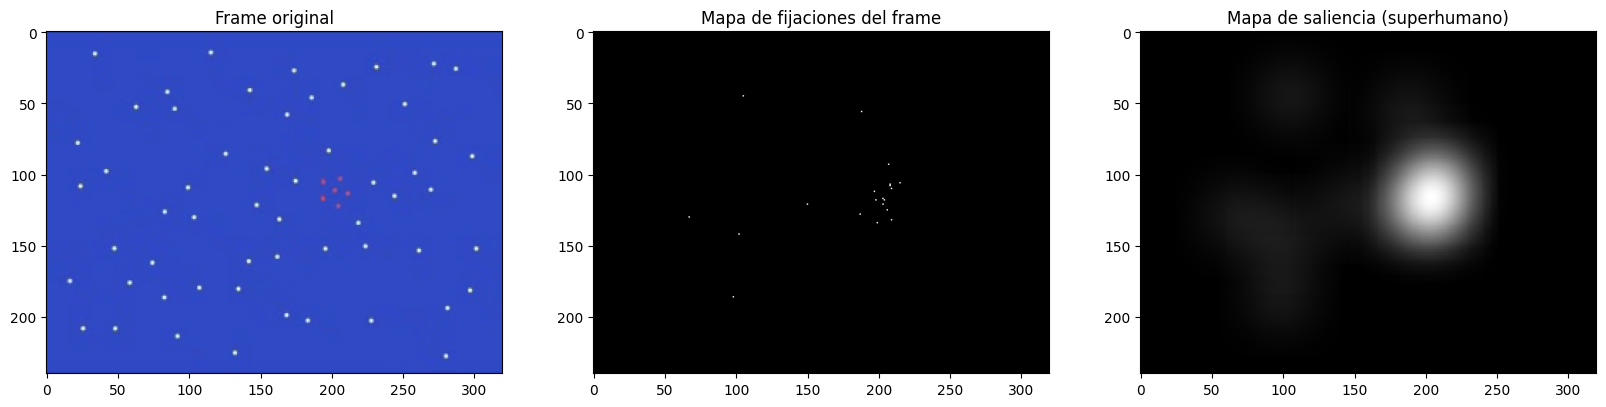

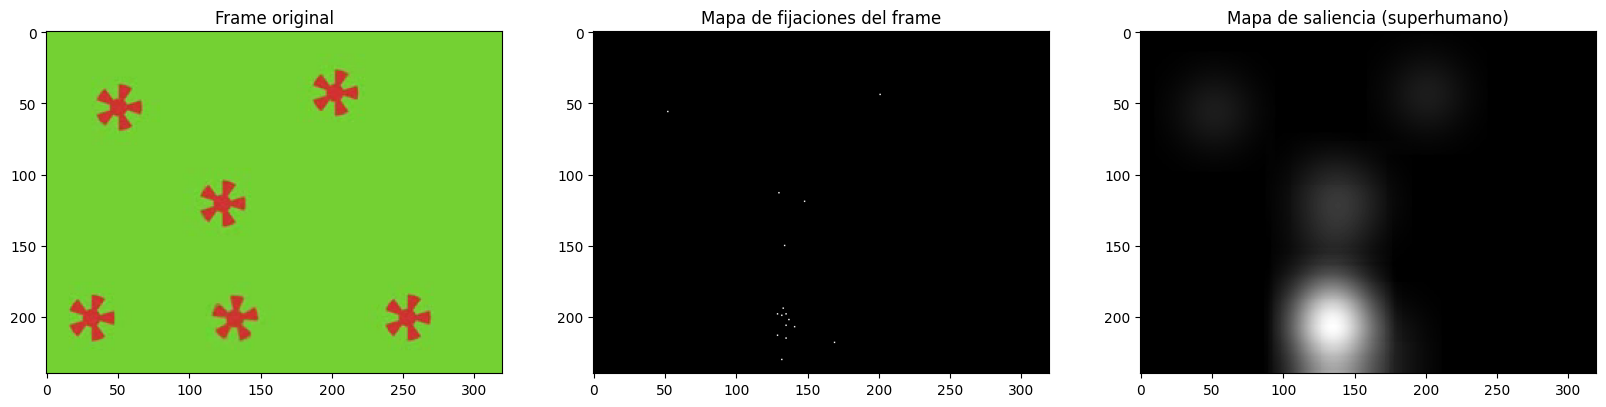

In [38]:
# Recorremos la base de datos con los videos iniciales
for ivideo in range(fixation_maps['EyeTrackVDB'].shape[0]):
    # Leemos el video y el mapa de fijación correspondiente
    name_video = fixation_maps['EyeTrackVDB'][ivideo]['Name'][0][0]
    video = cv2.VideoCapture(videos_path + name_video)

    if (video.isOpened() == False):
        print("Error en la apertura del fichero {}".format(videos_path + name_video))

    # Recuperamos as propieades do video.
    frame_w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))


    # Obtener el número total de frames en el video
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Generar un número aleatorio entre 0 y el número total de frames
    random_frame_number = np.random.randint(0, total_frames - 1)

    # Establecer la posición del frame en el número aleatorio
    video.set(cv2.CAP_PROP_POS_FRAMES, random_frame_number)

    # Leer el frame aleatorio
    ret, random_frame = video.read()

    # Leer las fijaciones del frame aleatorio)
    random_fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,random_frame_number][:,0:2]

    # Construimos el mapa de fijaciones del frame aleatorio
    # Frame aleatorio:
    random_ground_truth = np.zeros((frame_h,frame_w))
    for ifix in range(random_fix.shape[0]):
        # Puede haber fijaciones fuera de los margenes de la imagen
        if(int(random_fix[ifix][0]) < frame_h and int(random_fix[ifix][1]) < frame_w):
            random_ground_truth[int(random_fix[ifix][1]), int(random_fix[ifix][0])] = 255
    # Convolucionamos con una gaussiana las fijaciones para obtener el mapa de densidad de fijaciones
    random_density_map = (np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(random_ground_truth),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX))).astype(np.uint8)


    # Visualización
    plt.figure(figsize=[20, 15])
    plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(random_frame, cv2.COLOR_BGR2RGB), cmap='gray'), plt.title('Frame original')
    plt.subplot(1, 3, 2), plt.imshow(random_ground_truth, cmap='gray'), plt.title('Mapa de fijaciones del frame')
    plt.subplot(1, 3, 3), plt.imshow(random_density_map, cmap='gray'), plt.title('Mapa de saliencia (superhumano)')
    plt.show()

#### Obtenemos los valores de las métricas

In [39]:
# Definimos las listas donde guardaremos los distintos valores de las métricas para finalmente calcular la media
superhuman_AUCjudd_scores = []
superhuman_AUCshuff_scores = []
superhuman_NSS_scores = []
superhuman_CC_scores = []


# Recorremos la base de datos con los videos iniciales
for ivideo in range(fixation_maps['EyeTrackVDB'].shape[0]):
    # Leemos el video y el mapa de fijación correspondiente
    name_video = fixation_maps['EyeTrackVDB'][ivideo]['Name'][0][0]
    video = cv2.VideoCapture(videos_path + name_video)

    if (video.isOpened() == False):
        print("Error en la apertura del fichero {}".format(videos_path + name_video))

    # Recuperamos as propieades do video.
    frame_w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frame_count = 0
    ret, prev_frame = video.read()
    while(True):
        ret, current_frame = video.read()
        if(not ret):
            break

        # Leemos las fijaciones correspondientes al frame actual y a otro frame aleatorio
        fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,frame_count][:,0:2]
        random_frame = np.random.randint(len(fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0]))
        random_fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,random_frame][:,0:2]

        # Construimos los mapas de fijaciones del frame actual y del aleatorio
        # Frame actual:
        ground_truth = np.zeros((frame_h,frame_w))
        for ifix in range(fix.shape[0]):
            # Puede haber fijaciones fuera de los margenes de la imagen
            if(int(fix[ifix][0]) < frame_h and int(fix[ifix][1]) < frame_w):
                ground_truth[int(fix[ifix][1]), int(fix[ifix][0])] = 255
        # Convolucionamos con una gaussiana las fijaciones para obtener el mapa de densidad de fijaciones
        density_map = (np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(ground_truth),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX))).astype(np.uint8)

        # Frame aleatorio:
        random_ground_truth = np.zeros((frame_h,frame_w))
        for ifix in range(random_fix.shape[0]):
            # Puede haber fijaciones fuera de los margenes de la imagen
            if(int(random_fix[ifix][0]) < frame_h and int(random_fix[ifix][1]) < frame_w):
                random_ground_truth[int(random_fix[ifix][1]), int(random_fix[ifix][0])] = 255
        # Convolucionamos con una gaussiana las fijaciones para obtener el mapa de densidad de fijaciones
        random_density_map = (np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(random_ground_truth),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX))).astype(np.uint8)

        # Nuestro mapa de saliencia será el mapa de densidades del frame actual
        superhuman_sm = density_map

        # Calculamos las diferentes métricas para cada frame
        superhuman_AUCjudd_scores.append(AUC_judd(superhuman_sm, ground_truth))
        superhuman_AUCshuff_scores.append(AUC_shuff(superhuman_sm, ground_truth, random_ground_truth))
        superhuman_NSS_scores.append(NSS(superhuman_sm, ground_truth))
        superhuman_CC_scores.append(CC(superhuman_sm, density_map))

        # Actualizamos los frames
        frame_count += 1
        prev_frame = current_frame

# Calculamos la media de la métricas
superhuman_AUCjudd_mean = np.mean(np.nan_to_num(superhuman_AUCjudd_scores))
superhuman_AUCshuff_mean = np.mean(np.nan_to_num(superhuman_AUCshuff_scores))
superhuman_NSS_mean = np.mean(np.nan_to_num(superhuman_NSS_scores))
superhuman_CC_mean = np.mean(np.nan_to_num(superhuman_CC_scores))

/tmp/ipykernel_13103/1916560951.py:3: RuntimeWarning: invalid value encountered in divide
  norm_s_map = (s_map - np.min(s_map))/((np.max(s_map)-np.min(s_map))*1.0)
/tmp/ipykernel_13103/1916560951.py:100: RuntimeWarning: invalid value encountered in scalar divide
  tp = num_overlap/(num_fixations*1.0)
/tmp/ipykernel_13103/1916560951.py:104: RuntimeWarning: invalid value encountered in scalar divide
  fp = len(np.where(r_sal_map>thresh)[0])/(num_fixations*1.0)
/tmp/ipykernel_13103/1916560951.py:119: RuntimeWarning: invalid value encountered in divide
  s_map_norm = (s_map - np.mean(s_map))/np.std(s_map)
/tmp/ipykernel_13103/1916560951.py:129: RuntimeWarning: invalid value encountered in divide
  s_map_norm = (s_map - np.mean(s_map))/np.std(s_map)
/tmp/ipykernel_13103/1916560951.py:130: RuntimeWarning: invalid value encountered in divide
  gt_norm = (gt - np.mean(gt))/np.std(gt)


#### **Modelo 2**: utilizando como mapa de saliencia la suma de todos los mapas de fijaciones de la base de datos.

##### Sumamos todos los mapas de fijaciones y finalmente convolucionamos con la gaussiana para crear el mapa de saliencia del superhumano

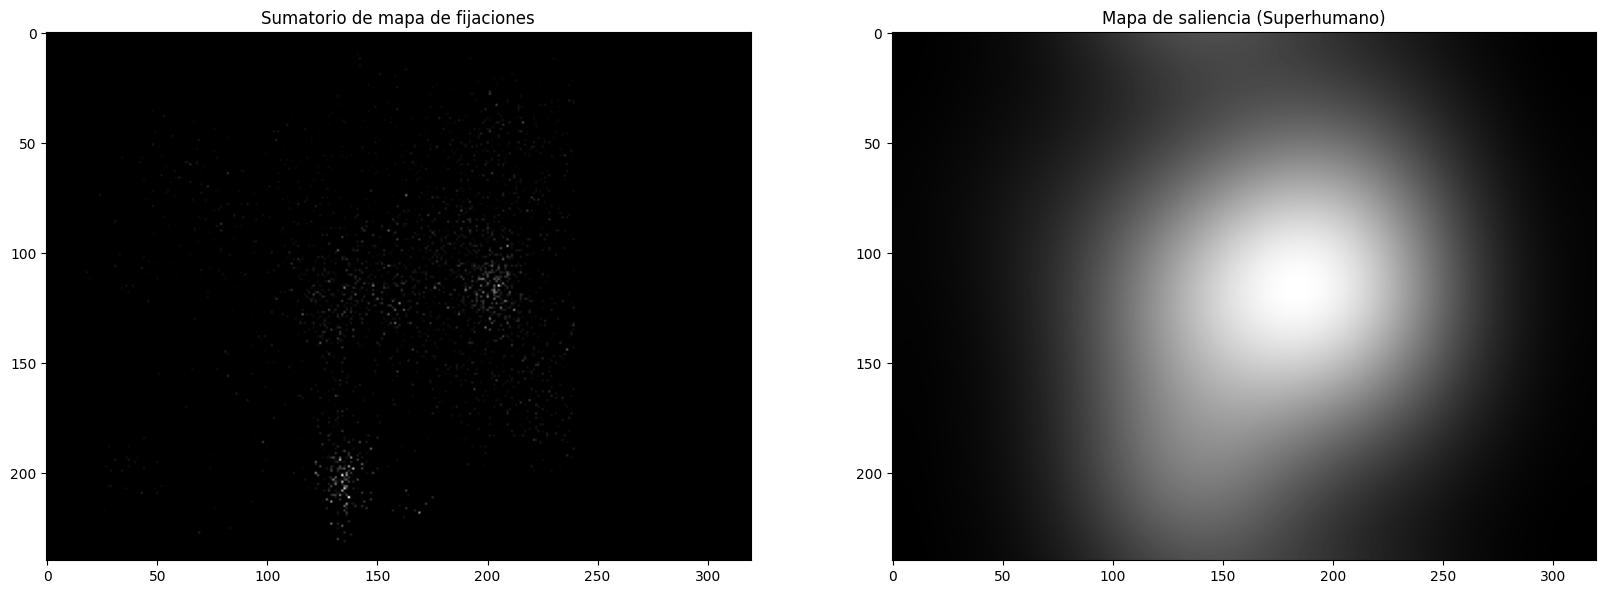

In [40]:
# Inicializamos la variable donde sumaremos todos los mapas de fijaciones
SUMfixation_maps = 0

# Recorremos la base de datos con los videos iniciales
for ivideo in range(fixation_maps['EyeTrackVDB'].shape[0]):
    # Leemos el video y el mapa de fijación correspondiente
    name_video = fixation_maps['EyeTrackVDB'][ivideo]['Name'][0][0]
    video = cv2.VideoCapture(videos_path + name_video)

    if (video.isOpened() == False):
        print("Error en la apertura del fichero {}".format(videos_path + name_video))

    # Recuperamos as propieades do video.
    frame_w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frame_count = 0
    while(True):
        ret, current_frame = video.read()
        if(not ret):
            break

        # Leemos las fijaciones correspondientes al frame actual y a otro frame aleatorio
        fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,frame_count][:,0:2]
        random_frame = np.random.randint(len(fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0]))
        random_fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,random_frame][:,0:2]

        # Construimos los mapas de fijaciones del frame actual y del aleatorio
        # Frame actual:
        ground_truth = np.zeros((frame_h,frame_w))
        for ifix in range(fix.shape[0]):
            # Puede haber fijaciones fuera de los margenes de la imagen
            if(int(fix[ifix][0]) < frame_h and int(fix[ifix][1]) < frame_w):
                ground_truth[int(fix[ifix][1]), int(fix[ifix][0])] = 255

        # Sumamos el ground_truth actual
        SUMfixation_maps += ground_truth

        # Actualizamos el contador de frames
        frame_count += 1

# Aplicamos la convolución al sumatorio para obtener el mapa de saliencia
superhumanSUM_sm = cv2.filter2D(SUMfixation_maps, -1, build_superhumanFOV(0.75, 21), borderType=cv2.BORDER_WRAP)

# Visualización
plt.figure(figsize=[20, 15])
plt.subplot(1, 2, 1), plt.imshow(SUMfixation_maps, cmap='gray'), plt.title('Sumatorio de mapa de fijaciones')
plt.subplot(1, 2, 2), plt.imshow(superhumanSUM_sm, cmap='gray'), plt.title('Mapa de saliencia (Superhumano)')
plt.show()

#### Obtenemos los valores de las métricas

In [41]:
# Definimos las listas donde guardaremos los distintos valores de las métricas para finalmente calcular la media
superhumanSUM_AUCjudd_scores = []
superhumanSUM_AUCshuff_scores = []
superhumanSUM_NSS_scores = []
superhumanSUM_CC_scores = []


# Recorremos la base de datos con los videos iniciales
for ivideo in range(fixation_maps['EyeTrackVDB'].shape[0]):
    # Leemos el video y el mapa de fijación correspondiente
    name_video = fixation_maps['EyeTrackVDB'][ivideo]['Name'][0][0]
    video = cv2.VideoCapture(videos_path + name_video)

    if (video.isOpened() == False):
        print("Error en la apertura del fichero {}".format(videos_path + name_video))

    # Recuperamos as propieades do video.
    frame_w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frame_count = 0
    ret, prev_frame = video.read()
    while(True):
        ret, current_frame = video.read()
        if(not ret):
            break

        # Leemos las fijaciones correspondientes al frame actual y a otro frame aleatorio
        fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,frame_count][:,0:2]
        random_frame = np.random.randint(len(fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0]))
        random_fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,random_frame][:,0:2]

        # Construimos los mapas de fijaciones del frame actual y del aleatorio
        # Frame actual:
        ground_truth = np.zeros((frame_h,frame_w))
        for ifix in range(fix.shape[0]):
            # Puede haber fijaciones fuera de los margenes de la imagen
            if(int(fix[ifix][0]) < frame_h and int(fix[ifix][1]) < frame_w):
                ground_truth[int(fix[ifix][1]), int(fix[ifix][0])] = 255
        # Convolucionamos con una gaussiana las fijaciones para obtener el mapa de densidad de fijaciones
        density_map = (np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(ground_truth),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX))).astype(np.uint8)

        # Frame aleatorio:
        random_ground_truth = np.zeros((frame_h,frame_w))
        for ifix in range(random_fix.shape[0]):
            # Puede haber fijaciones fuera de los margenes de la imagen
            if(int(random_fix[ifix][0]) < frame_h and int(random_fix[ifix][1]) < frame_w):
                random_ground_truth[int(random_fix[ifix][1]), int(random_fix[ifix][0])] = 255

        # Calculamos las diferentes métricas para cada frame
        superhumanSUM_AUCjudd_scores.append(AUC_judd(superhumanSUM_sm, ground_truth))
        superhumanSUM_AUCshuff_scores.append(AUC_shuff(superhumanSUM_sm, ground_truth, random_ground_truth))
        superhumanSUM_NSS_scores.append(NSS(superhumanSUM_sm, ground_truth))
        superhumanSUM_CC_scores.append(CC(superhumanSUM_sm, density_map))

        # Actualizamos los frames
        frame_count += 1
        prev_frame = current_frame

# Calculamos la media de la métricas
superhumanSUM_AUCjudd_mean = np.mean(np.nan_to_num(superhumanSUM_AUCjudd_scores))
superhumanSUM_AUCshuff_mean = np.mean(np.nan_to_num(superhumanSUM_AUCshuff_scores))
superhumanSUM_NSS_mean = np.mean(np.nan_to_num(superhumanSUM_NSS_scores))
superhumanSUM_CC_mean = np.mean(np.nan_to_num(superhumanSUM_CC_scores))

/tmp/ipykernel_13103/1916560951.py:100: RuntimeWarning: invalid value encountered in scalar divide
  tp = num_overlap/(num_fixations*1.0)
/tmp/ipykernel_13103/1916560951.py:104: RuntimeWarning: divide by zero encountered in scalar divide
  fp = len(np.where(r_sal_map>thresh)[0])/(num_fixations*1.0)
/tmp/ipykernel_13103/1916560951.py:104: RuntimeWarning: invalid value encountered in scalar divide
  fp = len(np.where(r_sal_map>thresh)[0])/(num_fixations*1.0)
/tmp/ipykernel_13103/1916560951.py:130: RuntimeWarning: invalid value encountered in divide
  gt_norm = (gt - np.mean(gt))/np.std(gt)


## Resultados

In [42]:
print('Número de videos muestreados: {}'.format(nvideos))

# Listas
metrics = ['AUCjudd', 'AUCshuff', 'NSS', 'CC']
models = ['PFT', 'PFT+Color', 'PD', 'PD+Color', 'Gaussian', 'Superhuman', 'SuperhumanSUM']
score_lists = [[PFT_AUCjudd_mean, PFTColor_AUCjudd_mean, PD_AUCjudd_mean, PDColor_AUCjudd_mean, gaussian_AUCjudd_mean, superhuman_AUCjudd_mean, superhumanSUM_AUCjudd_mean],
               [PFT_AUCshuff_mean, PFTColor_AUCshuff_mean, PD_AUCshuff_mean, PDColor_AUCshuff_mean, gaussian_AUCshuff_mean, superhuman_AUCshuff_mean, superhumanSUM_AUCshuff_mean],
               [PFT_NSS_mean, PFTColor_NSS_mean, PD_NSS_mean, PDColor_NSS_mean, gaussian_NSS_mean, superhuman_NSS_mean, superhumanSUM_NSS_mean],
               [PFT_CC_mean, PFTColor_CC_mean, PD_CC_mean, PDColor_CC_mean, gaussian_CC_mean, superhuman_CC_mean, superhumanSUM_CC_mean]]

# Dataframe con las métricas
data = {'Modelo': models}
for metric, score_list in zip(metrics, score_lists):
    sorted_scores = sorted(score_list, reverse=True)
    data[metric] = score_list
    data[f'{metric} Rank'] = [sorted_scores.index(score) + 1 for score in score_list]

df = pd.DataFrame(data)

# Mostramos el DataFrame
df

Número de videos muestreados: 6


,Modelo,AUCjudd,AUCjudd Rank,AUCshuff,AUCshuff Rank,NSS,NSS Rank,CC,CC Rank
0,PFT,0.793816,5,0.763884,3,2.001287,3,0.419645,5
1,PFT+Color,0.826590,4,0.796662,2,2.478678,2,0.496363,2
2,PD,0.682278,7,0.639763,5,1.376967,6,0.330556,7
3,PD+Color,0.721718,6,0.684819,4,1.501136,4,0.362408,6
4,Gaussian,0.840463,3,0.485499,7,1.229178,7,0.435023,4
5,Superhuman,0.973053,1,0.915603,1,4.241877,1,0.998525,1
6,SuperhumanSUM,0.863601,2,0.600893,6,1.431694,5,0.483100,3


### Análisis
La estrategia utilizada para poder utilizar las funciones en vídeos consiste en analizar todos sus frames, obteniendo para cada uno su valor de cada métrica, almacenarlo en una lista y finalmente calcular la media de todos estos valores para obtener un valor final medio del modelo.

Comparando los resultados de los dos métodos implementados, de manera similar al caso de la saliencia estática, se puede comprobar que incluir la información de color a la hora de obtener el mapa de saliencia mejora el valor de las métricas y del rendimiento de los modelos, consiguiendo así una saliencia más parecida a las fijaciones reales de los humanos a la hora de observar los vídeos.

También podemos observar un cambio bastante notable en el valor de las métricas AUC del modelo de la gaussiana centrada, esto se debe a que AUC shuffle se trata de una métrica más robusta que AUC judd, ya que esta versión compensa el sesgo del conjunto de datos al puntuar una prioridad central al azar.

Podemos ver que al incluir el modelo de la gaussiana centrada en la imagen y el modelo del superhumano tenemos las cotas inferior y superior respectivamente, ya que en teoría ninguno de nuestros algoritmos debería de tener un rendimiento peor que el de la gaussiana a su vez que no debería de presentar un rendimiento mayor que el del superhumano.

Por otra parte, el modelo del superhumano creado con el sumatorio de todos los mapas de fijaciones (SuperhumanSUM) presenta el peor valor de todos (sin tener en cuenta el de la gaussiana) esto se puede deber a que, a diferencia del caso de saliencia estática, la base de datos de vídeos es bastante más pequeña que la de imágenes (6 vídeos vs 120 imágenes), por lo que cada vídeo tendrá un impacto mucho mayor en el mapa de saliencia final. Esta puede ser la razón de su reducido valor en las métricas, ya que algunos de estos vídeos presentan los objetos salientes en los extremos de la ventana, mientras que el resto están situados en el centro de la imagen, obteniendo así un mapa de saliencia muy disperso.

## Visualizamos los mapas de densidades de fijaciones de los humanos para los 9 primeros frames

### Previamente almacenaremos los videos con duración de 9 frames en la carpeta "ouput" para posteriormente visualizarlos
### Nota: este kernel solo es necesario ejecutarlo una vez para almacenar los videos de salida con los mapas de saliencia

In [43]:
# Definimos el path a la carpeta de salida
path_to_out = "./output/"

#Lazo para todos os videos da base de datos:
for ivideo in range(fixation_maps['EyeTrackVDB'].shape[0]):
    # Leemos el video y el mapa de fijación correspondiente
    name_video = fixation_maps['EyeTrackVDB'][ivideo]['Name'][0][0]
    video = cv2.VideoCapture(videos_path + name_video)

    if (video.isOpened() == False):
        print("Error en la apertura del fichero {}".format(videos_path + name_video))

    # Recuperamos las propiedades del video
    frame_w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_fps = int(video.get(cv2.CAP_PROP_FPS))

    # Especificamos los valores para fourcc
    fourcc_mp4 = cv2.VideoWriter_fourcc(*'mp4v')

    # Ralentizamos la velocidad de los videos grabados para visualizar con VLC.
    frame_fps = int(frame_fps/3)

    # Especificamos el nombre de salida
    file_out_fixDen = path_to_out + name_video

    # Creamos los objetos para escribir el video (avi o mp4)
    out_fixDen = cv2.VideoWriter(file_out_fixDen, fourcc_mp4, frame_fps, (frame_w,frame_h))

    # Leemos los 9 primeros frames
    frame_count = 0
    while True:
        ret, frame = video.read()
        if(not ret or frame_count == 9):
            break

        # Leer las fijaciones del frame
        fix = fixation_maps['EyeTrackVDB'][ivideo]['Frame'][0]['FixL'][0,frame_count][:,0:2]

        # Construir el mapa de densidad de fijaciones
        map_fix_frame = np.zeros((frame_h,frame_w))
        for ifix in range(fix.shape[0]):
            # Puede haber fijaciones fuera de los margenes de la imagen
            if(int(fix[ifix][0]) < frame_h and int(fix[ifix][1]) < frame_w):
                map_fix_frame[int(fix[ifix][1]), int(fix[ifix][0])] = 255   # Mapa de fijaciones
        # Convolucionamos con una gaussiana las fijaciones para obtener el mapa de densidad de fijaciones
        map_den_fix = (np.floor(cv2.normalize(cv2.GaussianBlur(np.float32(map_fix_frame),(85,85),20,20), None, 0, 255, cv2.NORM_MINMAX))).astype(np.uint8)

        # Incrementamos el contador de frames
        frame_count += 1

        # Escribimos los videos en la carpeta indicada
        tmp = np.zeros_like(frame)
        tmp = cv2.merge([map_den_fix, map_den_fix, map_den_fix])
        out_fixDen.write(tmp)

    # Liberamos memoria e pechamos os fluxos de video
    video.release()
    out_fixDen.release()

### Visualización de los 2 casos con el fenómeno más acentuado

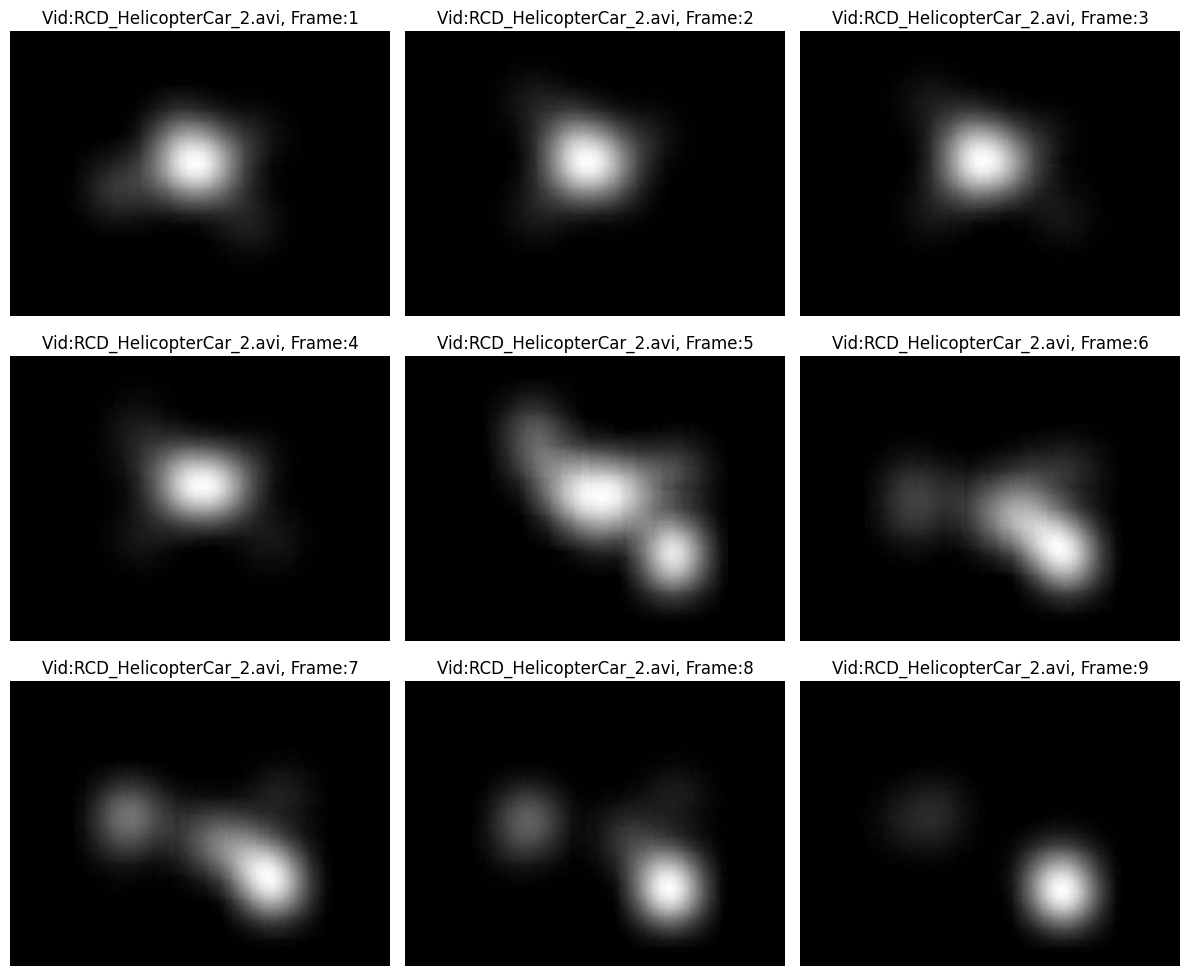

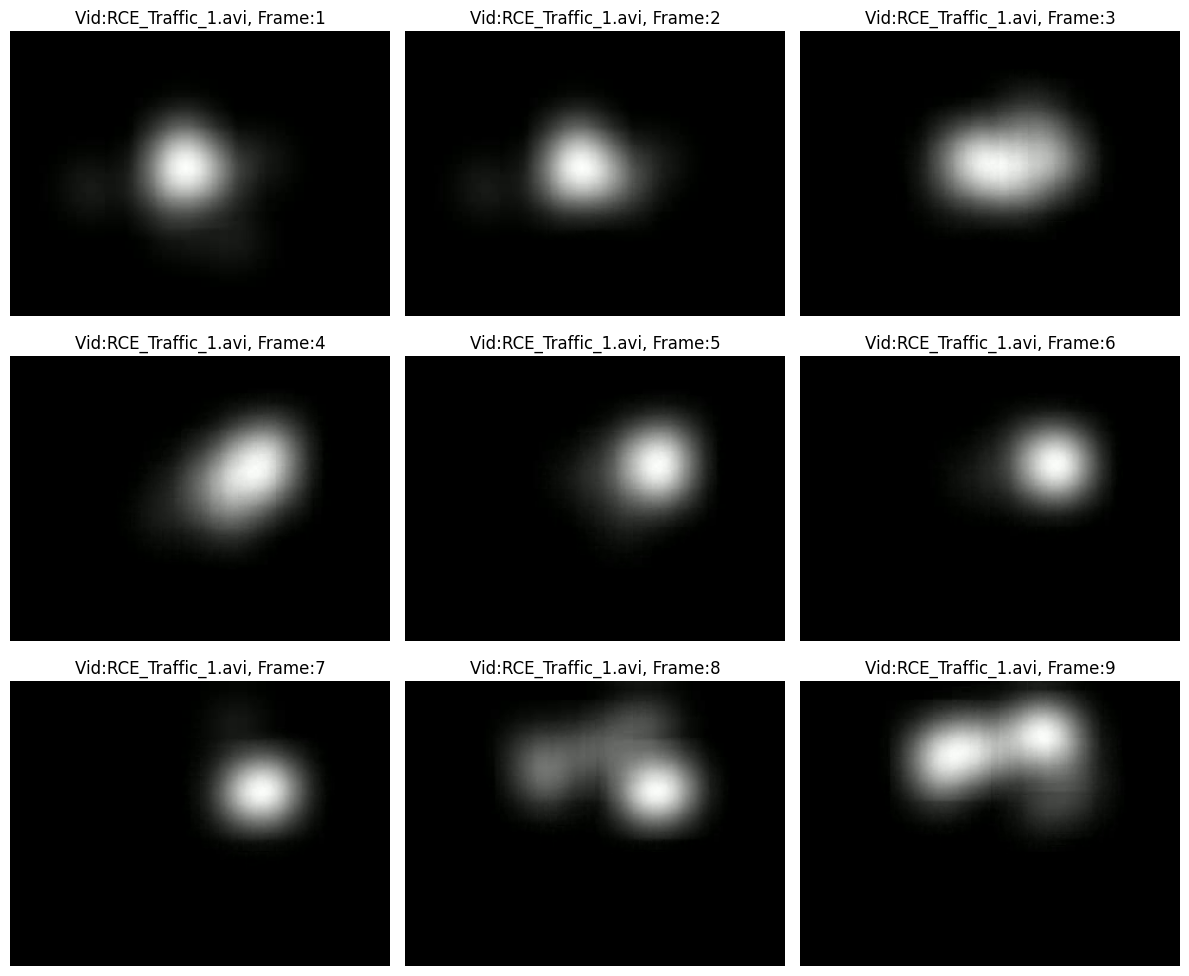

In [44]:
# Función para obtener los primeros 9 frames
def obtener_primeros_frames(video_path):
    video = cv2.VideoCapture(video_path)
    frames = []
    for i in range(9):
        ret, frame = video.read()
        if ret:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    video.release()
    return frames

# Directorio con los videos
videos_path = './output/'
video_titles = ['RCD_HelicopterCar_2.avi','RCE_Traffic_1.avi']

for i, title in enumerate(video_titles):
    # Crear el subplot para mostrar los frames
    fig, axs = plt.subplots(3, 3, figsize=(12, 10))
    axs = axs.flatten()
    frames = obtener_primeros_frames(videos_path+title)
    for j, frame in enumerate(frames):
        axs[j].imshow(frame)
        axs[j].axis('off')
        axs[j].set_title('Vid:{}, Frame:{}'.format(title, j+1))

    plt.tight_layout()
    plt.show()

### Análisis del fenómeno
Observando los primeros 9 frames de estos mapas de densidades de fijaciones de los humanos podemos ver que varían bastante a partir del 4º frame para el primer video y a partir del 7º para el segundo, esto se debe a que antes de esos frames el humano no tiene un objetivo claro en el que fijarse por lo que centra su mirada en el centro de la imagen ya que nuestro cerebro está entrenado de esta forma, es decir, inicialmente damos por hecho que la localización del objeto en el que nos tenemos que fijar en la imagen va a estar situado en el centro de esta. Posteriormente, si el objeto no se encuentra en el centro de la imagen, la mirada es desviada a la nueva localización de este.